# Option 3 - Spread of Covid 19

Look at this document for reference,
https://www.kaggle.com/anandhuh/covid19-in-world-countrieslatest-data

In [1]:
# (1) Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split

#  Import the machine learning model
from sklearn.ensemble import RandomForestClassifier
# Import the function for evaluating the model
from sklearn.model_selection import cross_val_score

# Import GridSearchCV for finding the model with the best parameters
from sklearn.model_selection import GridSearchCV

# Import functions for measuring metrics of the ml model
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Step 1 : Understand the given data 
 In this section, we try to get an overview of our dataset. To do that we: 
- Use the head method to look at the features that the dataset has.
- Use the describe method to get some numerical insights about the dataset we have

In [2]:
# (2) Import the CSV file
covid19Df = pd.read_csv('./worldwide covid data.csv')

In [3]:
# (3) Explore data (for example, see what is categorial and numerical)
covid19Df.head(2) 

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Cases/1M population,Deaths/1M population,Total Tests,Tests/1M population,Population
0,Afghanistan,156307,7281,128791.0,20235.0,3898,182,774655.0,19319.0,40097200
1,Albania,186222,2937,175451.0,7834.0,64805,1022,1311540.0,456411.0,2873596


In [4]:
covid19Df.describe()

,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Cases/1M population,Deaths/1M population,Total Tests,Tests/1M population,Population
count,1.960000e+02,196.000000,1.940000e+02,1.940000e+02,196.000000,196.000000,1.920000e+02,1.920000e+02,1.960000e+02
mean,1.266763e+06,25658.688776,1.150839e+06,9.260771e+04,56113.617347,914.311224,2.094107e+07,1.060358e+06,4.008576e+07
std,4.593222e+06,84846.606103,4.046744e+06,6.744275e+05,51997.542468,955.591341,7.512503e+07,1.876692e+06,1.482140e+08
min,2.621000e+03,3.000000,5.500000e+01,2.000000e+00,68.000000,3.000000,1.468900e+04,3.287000e+03,3.402600e+04
25%,2.237675e+04,333.500000,1.590175e+04,6.695000e+02,5636.000000,112.500000,3.540520e+05,1.051550e+05,1.987078e+06
50%,1.778875e+05,2434.500000,1.402300e+05,7.220000e+03,46790.000000,628.000000,1.978244e+06,4.632715e+05,8.907116e+06
75%,6.605052e+05,11778.500000,6.085508e+05,3.443275e+04,91629.750000,1560.750000,1.112483e+07,1.280447e+06,2.893874e+07
max,4.699977e+07,768847.000000,3.700999e+07,9.220934e+06,231328.000000,5964.000000,7.034355e+08,1.481471e+07,1.439324e+09


For the purpose of this project, we decided as a group that we want to train our model to classify the countries to either have **High Death Rate** or **Low Death Rate**. To be able to do such a classification, we had to label the countries we have in our dataset into those two classes.</br> To find the death rate of a country we divided the $$Death Rate = \frac{
Deaths/1M population}{Total Cases/1M population} * 100$$ We took the mean death rate across all countries in the dataset. Any country that has a lower death rate than the average was classified as a Low Death Rate country and vice versa. 

In [5]:
featuresDf = covid19Df 
labels = [] # A list that will hold the labels of each country 
scores = [] # We will use the scores in EDA for representation of the data 
deathRateMean= (featuresDf['Deaths/1M population'].mean()/featuresDf['Total Cases/1M population'].mean()) *100
for index, row in featuresDf.iterrows():
    score = row['Deaths/1M population']/row['Total Cases/1M population']*100
    scores.append(score)
    if score < deathRateMean:
        labels.append(False)
    else: 
        labels.append(True)
        
# Add a new cloumn with the Death Rate 
# High Death Rate - > True 
# Low Death Rate -> False
featuresDf['High/ Low Death Rate'] = pd.DataFrame( data=labels, columns=['High/ Low Death Rate'] )
featuresDf['Death Rate Score'] = pd.DataFrame( data=scores, columns=['Death Rate Score'] )

#Look at the new table 
covid19Df.head(2) 

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Cases/1M population,Deaths/1M population,Total Tests,Tests/1M population,Population,High/ Low Death Rate,Death Rate Score
0,Afghanistan,156307,7281,128791.0,20235.0,3898,182,774655.0,19319.0,40097200,True,4.669061
1,Albania,186222,2937,175451.0,7834.0,64805,1022,1311540.0,456411.0,2873596,False,1.577039


### Step 2 : Feature Engineering  
 In this section, we tried to clean our data by checking the following: 
- Uniqueness 
- Correctness 
- No missing information 
- Relevancy
- Converting data types 
Finally, after cleaning our data we choose the label we want to train our machine learning model on. The label was "High/ Low Death Rate".

In [6]:
# (4) Choose the label and features
# Note: we moved this step to after cleaning the data 

In [7]:
# (a) unique
# Prove No Duplicates
print("Before Dropping Duplicates : ",featuresDf.shape,'\n')
featuresDf =featuresDf.drop_duplicates()
print("\nAfter Dropping Duplicates : ",featuresDf.shape)

Before Dropping Duplicates :  (196, 12) 


After Dropping Duplicates :  (196, 12)


In [8]:
# (b) correct 
#Make sure no value is negative 
#Finding Negative Values and Capping To 0.
for col in featuresDf.columns:
    if(col=='Country'):
        continue
    for j in range(len(featuresDf)):
        if(featuresDf[col][j]<0):
            featuresDf[col][j]=0

In [9]:
# (c) not missing
# First check the number of NULLS 
featuresDf.isna().sum()

Country                      0
Total Cases                  0
Total Deaths                 0
Total Recovered              2
Active Cases                 2
Total Cases/1M population    0
Deaths/1M population         0
Total Tests                  4
Tests/1M population          4
Population                   0
High/ Low Death Rate         0
Death Rate Score             0
dtype: int64

In [10]:
# Drop any rows with missing data 
featuresDf.dropna(inplace=True)

In [11]:
# Covert float64 into int64
featuresDf['Tests/1M population'] = featuresDf['Tests/1M population'].apply(np.int64)

In [12]:
# (D) relevant
# we will drop info after EDA as we will use the info in understanding the data 

### Step 3 : Exploratory Analysis 
We decided that the best way to visualize the data is to have a bar graph of the death rate for each country. 

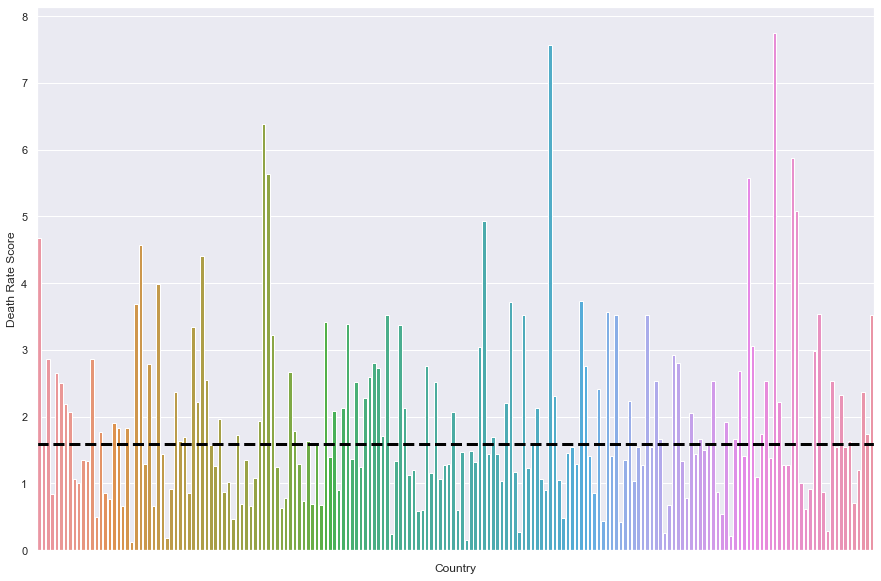

In [42]:
# (6) Confirm data is ready with further exploratory analysis
# for the illustration purposes we will check only the first 50 countries 
dataCovid19 = featuresDf[featuresDf['Death Rate Score'] < 10]
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.barplot(y="Death Rate Score", x="Country", data=dataCovid19)
ax.set(xticklabels=[])
mean =(featuresDf['Deaths/1M population'].mean()/featuresDf['Total Cases/1M population'].mean()) *100
plt.axhline(mean, color='black', linestyle='--', linewidth=3)
plt.show()

<AxesSubplot:xlabel='Total Cases', ylabel='Total Deaths'>

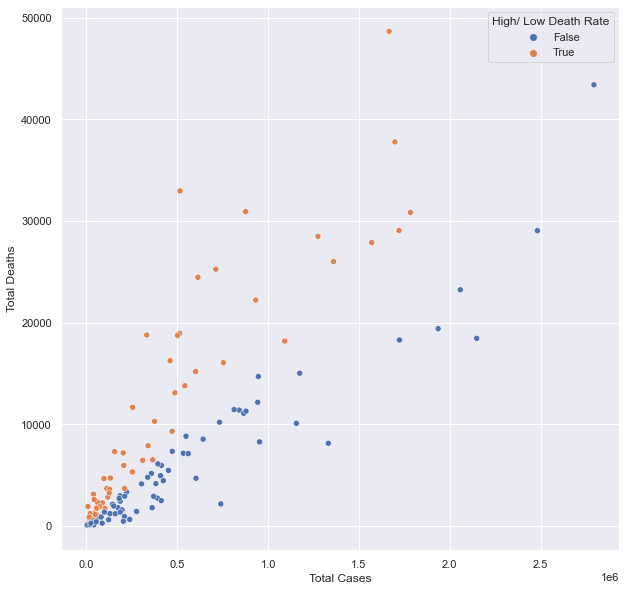

In [28]:
dataCovid19 = featuresDf[featuresDf['Total Deaths'] < 60000]
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(10,10)})
sns.scatterplot(data=dataCovid19, y="Total Deaths", x="Total Cases", hue="High/ Low Death Rate")

In [43]:
(featuresDf['Deaths/1M population'].mean()/featuresDf['Total Cases/1M population'].mean()) *100

1.5839677971741968

In [ ]:
# Now we will do Step 4 and drop irrleavent features 

# Droping irrelevant features 
featuresDf = featuresDf.drop(['Total Cases','Total Deaths','Total Recovered',
                             'Total Tests', 'Active Cases', 'Country', 'Death Rate Score'], axis=1,inplace =False)
# (4) Choose the label and features
LabelDf = featuresDf['High/ Low Death Rate']
featuresDf = featuresDf.drop('High/ Low Death Rate', axis=1,inplace =False)
print(featuresDf.shape)
print(LabelDf.shape)

### Step 4 : Machine Learning 
We decided to use Random Forest Classifier just like we used it in the course. We first splitted our data into : Training, Validating, and Testing. </br></br>
Then after checking with cross-validation that we can use Random Forest Classifier. We used GridSearchCV to pick the best 3 hyperparameters.</br></br>
We trained our data and validated those with the 3 best hyperparameters then we tested our code with the best hyperparameters that gave us high accuracy with a precision and recall close to each other. 

In [ ]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

# Training we have 60% and 40% for test
trainF, testF, trainL, testL = train_test_split( featuresDf, LabelDf, test_size=0.4, random_state=42 )

# Divide the test into two parts: 50% for test and 50% for validation
testF, valF, testL, valL = train_test_split( testF, testL, test_size=0.5, random_state=42 )

In [ ]:
#Cross Validation 
# Instantiate the RandomForestClassifier
rfModel = RandomForestClassifier()
scores = cross_val_score( rfModel, trainF, trainL.values.ravel(), cv=5 )
print( scores )

We can see from the result of the cross-validation that the scores are close to each other. Meaning we can use this model to classify our countries.

In [ ]:
def printResults(gridSearchResults):

    print( 'Best ML Hyperparameters: {}\n'.format(gridSearchResults.best_params_) )

    means = gridSearchResults.cv_results_['mean_test_score']
    stnDvs = gridSearchResults.cv_results_['std_test_score']

    for mean, stnDvs, parameters in zip( means, stnDvs, gridSearchResults.cv_results_['params'] ):
        print(
            '{} (+/-{}) for {}'.format(
                round(mean, 3),
                round(stnDvs*2, 3),
                parameters
            ) 
        )

In [ ]:
# Instantiate the model and set the hyperparameters 
rfModel = RandomForestClassifier()

hyperparameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

# GridSearchCV will search and rank the models according their parameters
# Note:
# sklearn refers to 'hyperparameters' as 'parameters'
gridSearch = GridSearchCV( rfModel, hyperparameters, cv=5 )

# .fit() will have the model, rfModel, learn the parameters of the features
gridSearch.fit( trainF, trainL.values.ravel() )

printResults( gridSearch )

In [ ]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

rfModel1 = RandomForestClassifier(n_estimators=50, max_depth=None)
rfModel1.fit( trainF, trainL.values.ravel() )

rfModel2 = RandomForestClassifier(n_estimators=50, max_depth=20)
rfModel2.fit( trainF, trainL.values.ravel() )

rfModel3 = RandomForestClassifier(n_estimators=50, max_depth=10)
rfModel3.fit( trainF, trainL.values.ravel() )

In [ ]:
# (9) Evaluate the model metrics for Training (and/or Validation) data
for rfML in [rfModel1, rfModel2, rfModel3]:

    predictedLabels = rfML.predict(valF)

    # Find the metrics for the model: (a) accuracy, (b) precision, and (c) recall
    accuracy = round(accuracy_score(valL, predictedLabels), 3)
    precision = round(precision_score(valL, predictedLabels), 3)
    recall = round(recall_score(valL, predictedLabels), 3)

    # Print the metrics for each model
    print(
        'Max depth: {} and Estimators: {}'.format(rfML.max_depth, rfML.n_estimators)
    )
    print(
        'Accuracy: {}, Precision: {}, Recall: {}'.format( accuracy, precision, recall )
    )
    print('-------------------------------------------------')

In [ ]:
# We decided to use the third model becuase it has the closest recall and percision
# (10) Evaluate the model metris for Testing data
predictedLabels = rfModel2.predict( testF )

# Find the metrics for the model: (a) accuracy, (b) precision, and (c) recall
accuracy = round(accuracy_score(testL, predictedLabels), 3)
precision = round(precision_score(testL, predictedLabels), 3)
recall = round(recall_score(testL, predictedLabels), 3)

# Print the metrics for each model
print(
    'Max depth: {} and Estimators: {}'.format(rfML.max_depth, rfML.n_estimators)
)
print(
    'Accuracy: {}, Precision: {}, Recall: {}'.format( accuracy, precision, recall )
)
print('-------------------------------------------------')

In [ ]:
# (11) Use the model for prediction
newDataFeatures = {
    'Total Cases/1M population': [800,1000],
    'Deaths/1M population': [5, 500],
    'Tests/1M population': [10,50],
    'Population': [3000, 4000],
}

newDataFeaturesDf = pd.DataFrame(data=newDataFeatures)
print('Table of two anonymous country without death rate information:')
newDataFeaturesDf.head()

In [ ]:
predictedLabels = rfModel2.predict( newDataFeaturesDf )
newDataFeaturesDf['High/ Low Death Rate'] = predictedLabels
print('Table of two anonymous country with predicted death rate information:')
newDataFeaturesDf.head()

In [ ]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)
with open('PredictedDeathRate.csv', 'a', newline="") as f:
    newDataFeaturesDf.to_csv(f, index=False, header=True)
